# EXERCISE 4 - ML - Grundverfahren

**Package notes:**
We will use different packages in this exersice:
1. Scipy:
    We will use scipy for optimizing the hinge loss. Scipy provides a numerical optimization package with various solvers such as L-BFGS-B or SLSQP. 
2. Sklearn:
    Sklearn is a package providing different machine learning algorithms and tools. We will not use it for machine learning algorithms here but for loading the handwritten image data set, which we will use for applying probabilistic PCA.
3. CVXPY:
    CVXPY can be used to solve convex optimization problems such as a quadratic program. We will use the solver for optimizing for the dual problem of the SVMs.
    
You can install all those packages using pip (or conda or whatever).

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from typing import Union, Optional

## 1.) Probabilistic PCA with Expectation Maximization (7 Points)
In this exercise we will implement probabilistic PCA as discussed in the lecture. We will apply it on a toy task and the handwritten digit data set. We will also generate our own images. 

We start by defining some utilities for plotting. You don't need to do anything here.

In [2]:
def plot_data(X):
    plt.scatter(X[:, 0], X[:, 1], color='b')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xlim(0, 7)
    plt.ylim(0, 7)

def draw_2d_gaussian(mu: np.ndarray, sigma: np.ndarray, plt_std: float = 2, *args, **kwargs) -> None:
    (largest_eigval, smallest_eigval), eigvec = np.linalg.eig(sigma)
    phi = -np.arctan2(eigvec[0, 1], eigvec[0, 0])

    plt.scatter(mu[0:1], mu[1:2], marker="x", *args, **kwargs)

    a = plt_std * np.sqrt(largest_eigval)
    b = plt_std * np.sqrt(smallest_eigval)

    ellipse_x_r = a * np.cos(np.linspace(0, 2 * np.pi, num=200))
    ellipse_y_r = b * np.sin(np.linspace(0, 2 * np.pi, num=200))

    R = np.array([[np.cos(phi), np.sin(phi)], [-np.sin(phi), np.cos(phi)]])
    r_ellipse = np.array([ellipse_x_r, ellipse_y_r]).T @ R
    plt.plot(mu[0] + r_ellipse[:, 0], mu[1] + r_ellipse[:, 1], *args, **kwargs)


def plot_ev(mu, eig_vec_1, eig_vec_2):
    arrow_1_end = mu + eig_vec_1
    arrow_1_x = [mu[0], arrow_1_end[0]]
    arrow_1_y = [mu[1], arrow_1_end[1]]

    arrow_2_end = mu + eig_vec_2
    arrow_2_x = [mu[0], arrow_2_end[0]]
    arrow_2_y = [mu[1], arrow_2_end[1]]

    plt.plot(mu[0], mu[1], 'xr')
    plt.plot((mu + eig_vec_1)[0], (mu + eig_vec_1)[1], 'xr')
    plt.plot(arrow_1_x, arrow_1_y, 'red')
    plt.plot(arrow_2_x, arrow_2_y, 'red')

### Exercise 1.1) E-Step in Probabilistic PCA (3 Points)
We will implement the E-step in this exercise. Remember the equations in the E-Step as:
\begin{align*}
    \boldsymbol{\mu}_{\boldsymbol{z}|\boldsymbol{x}_i} = (\boldsymbol{W^TW}+\sigma^2\boldsymbol{I})^{-1}\boldsymbol{W}^T(\boldsymbol{x}_i-\boldsymbol{\mu}) \\
     \boldsymbol{\Sigma_{\boldsymbol{z}|\boldsymbol{x}_i}}=\sigma^2(\boldsymbol{W^TW}+\sigma^2\boldsymbol{I})^{-1},
\end{align*}
where $\boldsymbol{x}_i$ is one sample of the data, $\boldsymbol{W}$ is the transformation matrix, $\sigma^2$ is the variance and $\boldsymbol{\mu}$ is the mean of the likelihood model. <br><br>
Please note that we need to subtract the likelihood mean from the data. This subtraction previously was missing in the slides and we uploaded a corrected version. In the video recording you will also face that it is missing. However, the formula stated here is the one you should use.<br><br>
Implement the E-step of the EM-Algorithm for dimensionality reduction, according to the equations stated. The dimensions of the vectors/matrices are stated in the code snippet. Make sure that you have the same dimensionality
as stated in the comments. <br>
The hints in the comments might be useful.

In [3]:
def e_step(W, mu, X, sigma_quad):
    """
    Computes/Samples the Latent vectors in matrix Z given transformation matrix W and data X.
    :param W: Transformation matrix W (shape: [DxM], where D is data dimension, M is latent Dimension)
    :param X: Data matrix containing the data (shape: [NxD])
    :param sigma_quad: sigma^2, the variance of the likelihood (already in quadratic form) (shape: float)
    :return: returns mu_z, the mean of the posterior for each sample x (shape: [NxM])
             returns z_samples, the latent variables (shape: [MxN])
             returns var_z, the covariance of the posterior (shape: [MxM])
    """
    ###################
    # TODO: Implement the e-step for PPCA
    # Hint: np.linalg.solve is useful. You could also use np.linalg.inv. But np.linalg.solve is in general prefered
    # DONE
    
    # compute mean of z -> NxM
    mean = np.mean(X, axis=0) #1xD
    mean_x = np.tile(mean,(X.shape[0],1)) #NxD
    tmp = X - mean_x #NxD

    #                             MxD  DxM + 1x1           MxM = MxM               MxD   DxN = MxN
    mu_z = np.linalg.solve(np.add(W.T @ W, sigma_quad * np.identity(W.shape[1])), W.T @ tmp.T).T # NxM
    

    # compute covariance of z -> MxM
    #                                                            MxM                      MxM                 1x1
    var_z = np.linalg.solve(np.add(W.T @ W, sigma_quad * np.identity(W.shape[1])), np.identity(W.shape[1]) * sigma_quad) #MxM

    # sample z for each mean (mu_z is a Matrix (NxM), containg a mean for each data x_i) 
    z_samples = np.empty([mu_z.shape[0], mu_z.shape[1]])
    for i in range(mu_z.shape[0]):
        z_samples[i] = np.random.multivariate_normal(mu_z[i], var_z) 
    #z_samples = z_samples.T Fehler in der Beschreibung? beim E-Step soll Dimension NxM sein und nicht MxN
        
    
    ###################
    return mu_z, z_samples, var_z

### Exercise 1.2) M-Step in Probabilistic PCA (4Points)
We will implement the E-step in this exercise. The following equations can also be looked up in the slides
\begin{align*}
    \left(
    \begin{array}{c}
    \boldsymbol{\mu}\\
    \boldsymbol{W}
    \end{array}
    \right) = (\boldsymbol{Z^TZ})^{-1}\boldsymbol{Z}^T\boldsymbol{X},
\end{align*}
where 
\begin{align*}
\boldsymbol{X}=
    \left(
    \begin{array}{c}
    \boldsymbol{x}_1^T\\
    \vdots\\
    \boldsymbol{x}_n^T
    \end{array}
    \right),
\boldsymbol{Z}=
    \left(
    \begin{array}{c}
    1, \boldsymbol{z}_1^T\\
    \vdots\\
    1, \boldsymbol{z}_n^T
    \end{array}
    \right).
\end{align*}
$\boldsymbol{Z}$ is the matrix containing the bias and all the latent variable samples $\boldsymbol{z}_i$ and $\boldsymbol{X}$ is the matrix containing all data points $\boldsymbol{x}$. 
We further need to implement the variance:
\begin{align*}
    \sigma^2 = \frac{1}{ND}\sum_{i=1}^{N}\sum_{k=1}^{D}(y_{ik}- x_{ik})^2,
\end{align*}
where $\boldsymbol{y}_i=\boldsymbol{W}\boldsymbol{z}_i + \boldsymbol{\mu}$ and N is the number of data points and D is the dimension of the data $\boldsymbol{x}$. 
<br><br>
Implement the M-step of the EM-Algorithm for dimensionality reduction, according to the equations stated. The dimensions of the vectors/matrices are stated in the code snippet. Make sure that you have the same dimensionality
as stated in the comments. <br>
The hints in the comments might be useful.

In [4]:
def m_step(z_samples, X):
    """
    Computes the variance and the transformation matrix W given the latent vectors in z_samples and the data 
    in matrix X.
    :param Z: The latent variable vectors stored in z_samples (shape: [NxM])
    :param X: Data matrix containg the data (shape: [NxD])
    :return: returns the variance sigma_quad and the transformation matrix W (shape: [DxM]) 
    """
    ########################
    # TODO: Implement the m-step for PPCA
    # Hint: np.linalg.solve is useful. You could also use np.linalg.inv. But np.linalg.solve is in general prefered
    #DONE
    
    # create feature matrix Z
    ones = np.ones(z_samples.shape[0])
    Z = np.append([ones],z_samples.T, axis=0).T
    
    # Calculate W_tilde (Dx(M+1)) containg the mean of the likelihood and the projection matrix W
    
    #  (M+1)xN Nx(M+1)=(M+1)x(M+1)    (M+1)xN NxD=(M+1)xD
    W_tilde = np.linalg.solve(Z.T @ Z, Z.T @ X).T #Dx(M+1)
    mu = W_tilde[:,0] #Dx1
    W = W_tilde[:,1:] #DxM
    # Perform the predictions y in matrix Y
    #mu Dx1
    mu_n = np.tile(mu.T,(X.shape[0],1)).T #DxN
    #  DxM MxN = DxN + DxN
    Y = np.add(W @ z_samples.T, mu_n).T #NxD --> gleiche Dimensionen wie X
    
    # calculate variance sigma_quad scalar
    square = np.sum((Y-X)**2)
    
    sigma_quad = (1/(X.shape[0] * X.shape[1])) * square
    ########################
    return sigma_quad, mu, W

This is the EM-loop, where the E-step and the M-step alternates. You do not need to implement or change the function here.

In [5]:
def do_ppca(X: np.ndarray, n_principle_comps: int, num_iters: int = 50):
    np.random.seed(0)
    W = np.random.normal(size=(X.shape[1], n_principle_comps))
    mu_X = np.mean(X, axis=0)
    mu = mu_X.copy()
    sigma_quad = 1
    for i in range(num_iters):
        mu_z, z_samples, var_z = e_step(W, mu, X, sigma_quad)
        sigma_quad, mu, W = m_step(z_samples, X)
    return W, z_samples, var_z, sigma_quad, mu

#### 2D Toy Task from Lecture Notebook
We will first apply pPCA on the toy task, which we also had in the lecture notebook. Here is the data:

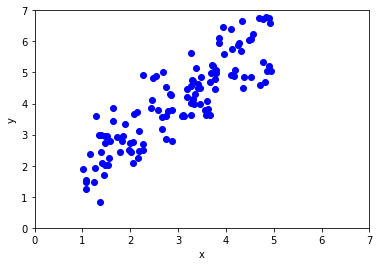

In [6]:
np.random.seed(0)

x = np.random.uniform(1,5, size=(120, 1))
y = x + 1 + np.random.normal(0, 0.7, size=x.shape)

X = np.concatenate((x, y), axis = 1)
plot_data(X)

Let's now perform the algorithm on the data. You do not need to change anything. 

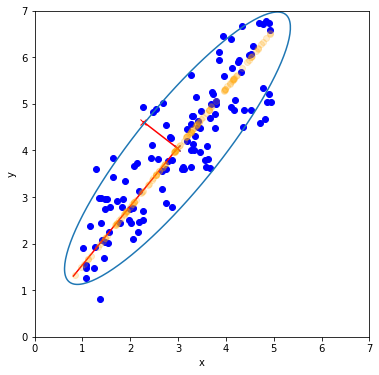

In [7]:
plt.figure(figsize=(6,6))

plot_data(X)

W, z_samples, var_z, sigma_quad, mu = do_ppca(X, n_principle_comps=1)

x_tilde = np.dot(W, z_samples.T).T + mu                         # reproject to high-dim space

C = np.dot(W, W.T) + sigma_quad*np.eye(W.shape[0])      # covariance of p(x) (reconstructed)

v, U = np.linalg.eig(np.cov(X.T))
mu_X = np.mean(X, axis=0)
plot_ev(mu_X, 2*np.sqrt(v[0])*U[:, 0], 2*np.sqrt(v[1])*U[:, 1])

draw_2d_gaussian(mu_X, C)

plt.plot(x_tilde[:, 0], x_tilde[:, 1], 'o', color='orange', alpha=0.2)   # reprojected data points

#### Hand-Written digits from Lecture Notebook
Next, we apply pPCA on the handwritten digits data set. We will consider the digit 3 only. Here is how the data looks like 

<Figure size 432x288 with 0 Axes>

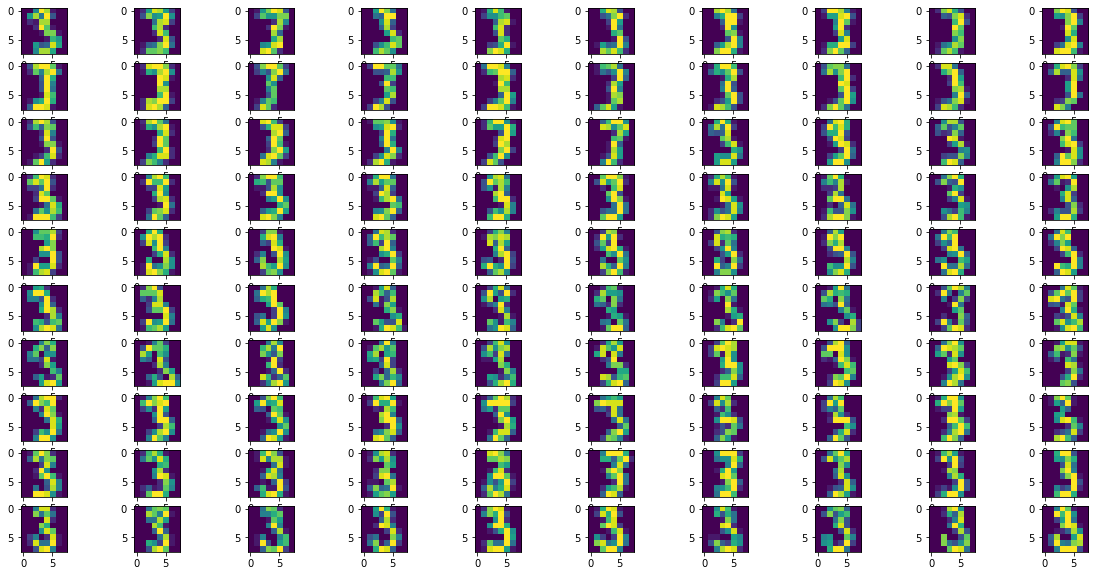

In [8]:
from sklearn.datasets import load_digits

digits = load_digits()
targets = digits.target

# get the images for digit 3 only
digits_3_indx = np.where(targets == 3)[0]
digit_3_data = digits.data[digits_3_indx]       # shape: (183, 64)  -> (8 x 8)
digit_3_targets = digits.target[digits_3_indx]       # only needed to verify that we load digit 3

mu_X_im = np.mean(digit_3_data, axis=0)

#Plot the original digit 3 images
plt.figure()
fig, axes = plt.subplots(10, 10, figsize=(20, 10))
for i, ax in enumerate(axes.flat):
     ax.imshow(digit_3_data[i].reshape(8, 8))

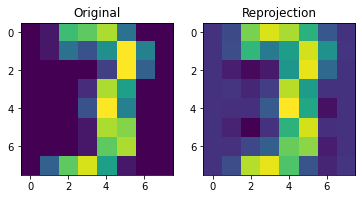

In [9]:
# let's perform ppca on the data
n_principle_comps = 10
W_im, z_samples_im, var_z_im, sigma_quad_im, mu_im = do_ppca(digit_3_data, n_principle_comps=n_principle_comps)
x_tilde_im = np.dot(W_im, z_samples_im.T).T + mu_im

considered_im = digit_3_data[15]
considered_im_x_tilde = x_tilde_im[15, :]

plt.figure()
plt.subplot(121)
plt.title('Original')
plt.imshow(considered_im.reshape(8, 8))

plt.subplot(122)
plt.title('Reprojection')
plt.imshow(considered_im_x_tilde.reshape(8,8))
plt.show()

Although the reprojected data does not look same, you should definitely see the similarity to the original image.

### Random Image generation
One advantage of pPCA is that we can generate random images. The generative process, as described in the lecture is implemented here.

<Figure size 432x288 with 0 Axes>

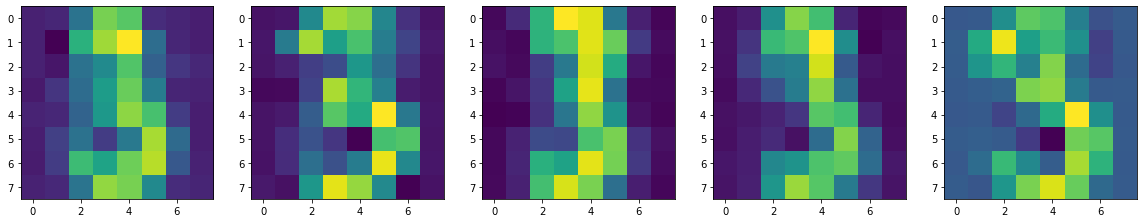

In [10]:
# Sample some vectors z
z = np.random.normal(size=(5, n_principle_comps))

# Project back to D-dim space
y = np.dot(W_im, z.T).T + mu_im

# Sample noise
eps = np.random.normal(scale=sigma_quad, size=y.shape)
# Get image
x = y + eps

plt.figure('Sampled Image')
fig, axes = plt.subplots(1, 5, figsize=(20, 10))
for i, ax in enumerate(axes.flat):
     ax.imshow(x[i].reshape(8, 8))

## 2.) Feature-Based Support Vector Machine (Hinge Loss) (5 Points)
In this exercise we will train a feature-based SVM on the two moons dataset using the hinge loss. We start by loading and visualizing the data. We will use the l-bfgs-b algorithm, provided by scipy.optimize for the optimization. All you need to know about this optimizer is that it is gradient based. Otherwise you can treat it as a black-box. Yet, it's also worth a closer look if you are interested. 

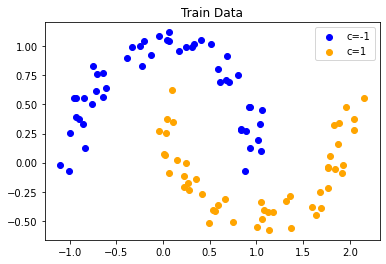

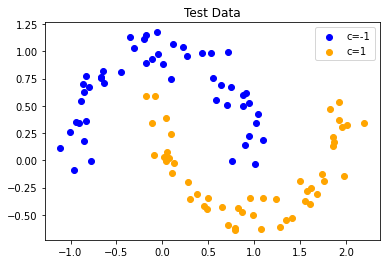

In [11]:
import scipy.optimize as opt

train_data = dict(np.load("two_moons.npz", allow_pickle=True))
train_samples = train_data["samples"]
train_labels = train_data["labels"]
# we need to change the labels for class 0 to -1 to account for the different labels used by an SVM 
train_labels[train_labels == 0] = -1 

test_data = dict(np.load("two_moons_test.npz", allow_pickle=True))
test_samples = test_data["samples"]
test_labels = test_data["labels"]
# we need to change the labels for class 0 to -1 to account for the different labels used by an SVM 
test_labels[test_labels == 0] = -1

plt.figure()
plt.title("Train Data")
plt.scatter(x=train_samples[train_labels == -1, 0], y=train_samples[train_labels == -1, 1], label="c=-1", c="blue")
plt.scatter(x=train_samples[train_labels == 1, 0], y=train_samples[train_labels == 1, 1], label="c=1", c="orange")
plt.legend()

plt.figure()
plt.title("Test Data")
plt.scatter(x=test_samples[test_labels == -1, 0], y=test_samples[test_labels == -1, 1], label="c=-1", c="blue")
plt.scatter(x=test_samples[test_labels == 1, 0], y=test_samples[test_labels == 1, 1], label="c=1", c="orange")
plt.legend()

#### Feature Function
From the logistic classification exercise earlier we already know that cubic features are a good choice for the two moons, so we will reuse them here.

In [12]:
def cubic_feature_fn(samples: np.ndarray) -> np.ndarray:
    """
    :param x: Batch of 2D data vectors [x, y] [N x dim]
    :return cubic features: [x**3, y**3, x**2 * y, x * y**2, x**2, y**2, x*y, x, y, 1]
    """
    x = samples[..., 0]
    y = samples[..., 1]
    return np.stack([x**3, y**3, x**2 * y, x * y**2, x**2, y**2, x*y, x, y, np.ones(x.shape[0])], axis=-1)

### Exercise 2.1) Hinge Loss Objective (2 Points) 

We will implement the hinge loss objective in this exercise. Its given by 
 $$\mathcal{L}_{\boldsymbol{X}, \boldsymbol{y}}(w) = \parallel \boldsymbol{w} \parallel^2 + C \sum_i^N  \max \left( 0, 1 - y_i \boldsymbol{w}^T \phi(\boldsymbol{x}_i) \right),$$
 where $\boldsymbol{w}$ are our model parameters, $\phi(\boldsymbol{x})$ are our features (here cubic) and the $y_i \in \lbrace{-1, 1\rbrace}$ are the class labels. 
 
 Fill in the code snippets below. This function implements the hinge loss.

In [13]:
def objective_svm(weights: np.ndarray, features: np.ndarray, labels: np.ndarray, slack_regularizer: float) -> float:
    """
    objective for svm training with hinge loss
    :param weights: current weights to evaluate (shape: [feature_dim])
    :param features: features of training samples (shape:[N x feature_dim])
    :param labels: class labels corresponding to train samples (shape: [N])
    :param slack_regularizer: Factor to weight the violation of margin with (C in slides)
    :returns svm (hinge) objective (scalar)
    """
    ### TODO ##########
    # DONE
    
    w_dist = np.sum(weights**2)
    n_sum  = np.sum(np.maximum(0, 1 - np.sum(labels[:,None]*weights * features, axis=1)))
        
    svm = w_dist + slack_regularizer * n_sum
    return svm    
    ###################


### Exercise 2.2) Hinge Loss Gradient (3 Points)
Derive and implement the gradient for the hinge loss objective stated above. For all non-differentiable points in the loss courves you can use any valid subgradient. 

**NOTE**: The derivation is explicitly part of the grading, so state it in the solution file, not just implement it. 

**Solution**:
$$\frac{\partial \mathcal{L}_{\boldsymbol{X}, \boldsymbol{y}}(\boldsymbol{w})} {\partial \boldsymbol{w}} = 2 \boldsymbol{w}  + C \sum_i^N \begin{cases} 0, & \mbox{if } y_i \boldsymbol{w}^T \phi(\boldsymbol{x}_i) \ge 1\\ -y_i\phi(\boldsymbol{x}_i), & \mbox{else} \end{cases}$$

In [14]:
def d_objective_svm(weights: np.ndarray, features: np.ndarray, labels: np.ndarray, slack_regularizer: float) -> np.ndarray:
    """
    gradient of objective for svm training with hinge loss
    :param weights: current weights to evaluate (shape: [feature_dim])
    :param features: features of training samples (shape: [N x feature_dim])
    :param labels: class labels corresponding to train samples (shape: [N])
    :param slack_regularizer: Factor to weight the violation of margin with (C in slides)
    :returns gradient of svm objective (shape: [feature_dim])
    """
    ### TODO ##########
    # DONE   
    
    conditions = np.sum(labels[:,None]*weights * features, axis=1)
    n_sum = np.sum((-labels[:,None]*features)[conditions<1], axis=0)
            
    gradient = weights*2 + n_sum*slack_regularizer
    return gradient
    ###################

### Train and Evaluate
Finally, we can tie everything together and get our maximum margin classifier. Here we are using the L-BFGS-B optimizer provided by Scipy. With $C=1000$ you should end up at a train accuracy of 1 and a test accuracy of 0.99, but feel free to play arround with $C$. 

      fun: 149.28565273822005
 hess_inv: <10x10 LbfgsInvHessProduct with dtype=float64>
      jac: array([-478.81451508,  600.06424439,  352.1235395 , -260.39062768,
       -294.14431616,  578.32915871,  106.95550413, -397.89369437,
       1091.04323992, 1005.56863462])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 324
      nit: 52
     njev: 324
   status: 0
  success: True
        x: array([ 5.39762875, -3.2310001 , -3.85863154,  4.36018891, -7.78463617,
        0.47527976,  0.14220714, -2.01943439, -1.71168478,  2.78431731])
Train Accuracy:  1.0
Test Accuracy:  0.99


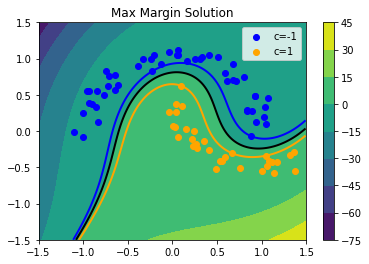

In [15]:
feature_fn = cubic_feature_fn
C = 1000.0

# optimization

train_features = feature_fn(train_samples)

# For detail see: https://docs.scipy.org/doc/scipy/reference/optimize.minimize-lbfgsb.html
res = opt.minimize(
    # pass objective
    fun=lambda w: objective_svm(w, train_features, train_labels, C),
    # pass initial point              
    x0=np.ones(train_features.shape[-1]),
    # pass function to evaluate gradient (in scipy.opt "jac" for jacobian)
    jac=lambda w: d_objective_svm(w, train_features, train_labels, C),
    # specify method to use
    method="l-bfgs-b")

print(res)
w_svm = res.x

# evaluation 
test_predictions = feature_fn(test_samples) @ w_svm
train_predictions = feature_fn(train_samples) @ w_svm

predicted_train_labels = np.ones(train_predictions.shape)
predicted_train_labels[train_predictions < 0] = -1
print("Train Accuracy: ", np.count_nonzero(predicted_train_labels == train_labels) / len(train_labels))

predicted_test_labels = np.ones(test_predictions.shape)
predicted_test_labels[test_predictions < 0] = -1
print("Test Accuracy: ", np.count_nonzero(predicted_test_labels == test_labels) / len(test_labels))

# plot train, contour, decision boundary and margins 
plt.figure()
plt.title("Max Margin Solution")
plt_range = np.arange(-1.5, 1.5, 0.01)
plt_grid = np.stack(np.meshgrid(plt_range, plt_range), axis=-1)
flat_plt_grid = np.reshape(plt_grid, [-1, 2])
plt_grid_shape = plt_grid.shape[:2]

pred_grid = np.reshape(feature_fn(flat_plt_grid) @ w_svm, plt_grid_shape)

#plt.contour(plt_grid[..., 0], plt_grid[..., 1], pred_grid, levels=[-1.0, 0.0, 1.0], colors=["blue", "black", "orange"])
plt.contour(plt_grid[..., 0], plt_grid[..., 1], pred_grid, levels=[-1, 0, 1], colors=('blue', 'black', 'orange'),
             linestyles=('-',), linewidths=(2,))
plt.contourf(plt_grid[..., 0], plt_grid[..., 1], pred_grid, levels=10)

plt.colorbar()

s0 =plt.scatter(x=train_samples[train_labels == -1, 0], y=train_samples[train_labels == -1, 1], label="c=-1", c="blue")
s1 =plt.scatter(x=train_samples[train_labels == 1, 0], y=train_samples[train_labels == 1, 1], label="c=1", c="orange")
plt.legend()

plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.show()

## 3.) Kernelized Support Vector Machine (8 Points) 

In this exercise we will implement another SVM on the two moons dataset, this time using the kernel trick.

The kernelized dual optimization problem for training an SVM is stated in the slides and can be written as a "Quadratic Program", i.e., an optimization of a quadratic objective under linear equality and inequality constraints - a problem of the form
$$ min_{\boldsymbol{x}} 0.5 \boldsymbol{x}^T \boldsymbol{Q} \boldsymbol{x} + \boldsymbol{q}^T \boldsymbol{x} ~~ \textrm{s.t.} ~~ \boldsymbol{G}\boldsymbol{x} \leq \boldsymbol{h}, ~~ \boldsymbol{Ax} = \boldsymbol{b}.$$ 

Efficient solvers for those kind of problems are well known and implemented in most programming languages. Here we use the CVXPY library.

You can treat this function as a black-box here but also feel free to have a closer look. CVXPY can be used not only for quadratic programs but in general, for any convex optimization problem. The documentation can be found here https://cvxopt.org/index.html


In [16]:
import cvxpy as cp

def solve_qp(Q: np.ndarray, q: np.ndarray,
             G:np.ndarray, h: Union[np.ndarray, float],
             A:np.ndarray, b: Union[np.ndarray, float], verbose=False) -> np.ndarray:
    """
    solves quadratic problem: min_x  0.5x^T Q x + q.^T x s.t. Gx <= h and Ax = b
      in the following 'dim' refers to the dimensionality of the optimization variable x
    :param Q: matrix of the quadratic term of the objective, (shape [dim, dim])
    :param q: vector for the linear term of the objective, (shape [dim])
    :param G: factor for lhs of the inequality constraint (shape [dim], or [dim, dim])
    :param h: rhs of the inequality constraint (shape [dim], or scalar)
    :param A: factor for lhs of the equality constraint (shape [dim], or [dim, dim])
    :param b: rhs of the equality constraint (shape [dim], or scalar)
    :return: optimal x (shape [dim])
    """
    x = cp.Variable(q.shape[0])
    prob = cp.Problem(cp.Minimize(0.5 * cp.quad_form(x, Q) + q.T @ x), constraints=[G @ x <= h, A @ x == b])
    prob.solve(verbose=verbose)
    return x.value

As you may have noticed the problem solved by the solver above differs from the one stated in the slides. Yet the equations from the slides can be reformulated, such that the solver can be used. 

### Exercise 3.1 (2 Points)  
Formulate the kernelized svm dual problem such that the solver can be used to solve it. I.e., state the quantities you need to pass for $\boldsymbol{Q}, \boldsymbol{q}, \boldsymbol{G}, \boldsymbol{h}, \boldsymbol{A}, \boldsymbol{b}$



Our problem is given by
\begin{align}
   & \max_{\lambda} \sum_i \lambda_i - \frac{1}{2}\sum_i \sum_j \lambda_i \lambda_j y_i y_j k(x_i,x_j)
\end{align}

Which is equivalent to

\begin{align} 
    & \min_{\lambda} - \sum_i \lambda_i + \frac{1}{2}\sum_i \sum_j \lambda_i \lambda_j y_i y_j k(x_i,x_j) \\
    &= \boldsymbol{-1} * \lambda + \frac{1}{2}\sum \lambda_i \lambda_j Q && \text{where } Q = y_i y_j \cdot k(x_i,x_j) \\
    &= \frac{1}{2}\sum \lambda_i \lambda_j Q + \boldsymbol{-1} * \lambda && \text{turn } \lambda \text{ into a matrix} \\
    &= \lambda^T Q \lambda + \boldsymbol{-1} * \lambda \\
\end{align}

This gives us the following representations requested by CVXOPT:
Disclaimer: This is for using it with C and therefore slack variables

$Q$ is given by $y_i y_j \cdot k(x_i,x_j)$

$q$ is a column vector full of $-1$, because 

$A$ is $y^T$

$b$ is 0

$G$ is an identity matrix which corresponds to the constraint that $\lambda_i \gt 0 \equiv -\lambda_i \lt 0$ 

$h$ is a zero column vector

### Exercise 3.2 (3 Points)
Implement the functions below so that the SVM can be trained and use for prediction


In [17]:
def get_gaussian_kernel_matrix(x: np.ndarray, sigma: float, y: Optional[np.ndarray] = None) -> np.ndarray:
    """ Computes Kernel matrix K(x,y) between two sets of data points x, y  for a Gaussian Kernel with bandwidth sigma.
    If y is not given it is assumed to be equal to x, i.e. K(x,x) is computed
    :param x: matrix containing first set of points (shape: [N, data_dim])
    :param sigma: bandwidth of gaussian kernel
    :param y: matrix containing second set of points (shape: [M, data_dim])
    :return: kernel matrix K(x,y) (shape [M, N])
    """
    if y is None:
        y = x
    ### TODO ######################
    # DONE
    Kernel_matrix = np.linalg.norm(x[:, None, :] - y[None, :, :], axis=-1)**2
    
    Kernel_matrix /= (-2*sigma**2)
    return np.exp(Kernel_matrix)
    
    ###############################

def fit_svm(samples: np.ndarray, labels: np.ndarray, sigma: float,verbose=True) -> np.ndarray:
    """
    fits an svm (with Gaussian Kernel)
    :param samples: samples to fit the SVM to (shape: [N, data_dim])
    :param labels: class labels corresponding to samples (shape: [N])
    :param sigma: bandwidth of gaussian kernel
    :return: "alpha" values, weight for each datapoint in the dual formulation of SVM (shape [N])
    """
    ### TODO ######################
    # DONE
    # rename our vars for a better overview
    X, y = samples, labels[:,None]
    m, n = X.shape
    
    Q = np.dot(y, y.T) * get_gaussian_kernel_matrix(X, sigma)

    q = -1.0 * np.ones((m, 1))

    A = y.T
    b = 0

    G = np.eye(m) * -1.0
    h = np.zeros(m) 
    
    # feed everything into quadratic solver
    alphas = solve_qp(Q,q,G,h,A,b, verbose=verbose)
    
    return alphas
    ###############################



def predict_svm(samples_query: np.ndarray, # X
                samples_train: np.ndarray, # Xtrain
                labels_train: np.ndarray, # y
                alphas: np.ndarray, 
                sigma: float) -> np.ndarray:
    """
    predict labels for query samples given training data and weights
    :param samples_query: samples to query (i.e., predict labels) (shape: [N_query, data_dim])
    :param samples_train: samples that where used to train svm (shape: [N_train, data_dim])
    :param labels_train: labels corresponding to samples that where used to train svm (shape: [N_train])
    :param alphas: alphas computed by training procedure (shape: [N_train])
    :param sigma: bandwidth of gaussian kernel
    :return: predicted labels for query points (shape: [N_query])
    """    
    
    ### TODO ######################
    X, y = samples_train, labels_train
    
    K_test  = get_gaussian_kernel_matrix(X, sigma, samples_query)
    K_train = get_gaussian_kernel_matrix(X, sigma)
    
    i = np.argmax(alphas) # important: we take *any* x_i with lambda > 0 to compute b; not *all*.
    assert alphas[i] > 0, "No positive weight in 'alphas'!"
    b = y[i] - np.sum(y * alphas * K_train[:,i])
    
    return np.dot((y * alphas).T, K_test) + b
    
    ###############################

We can now execute the code, train and visualize an SVM. For $\sigma = 0.3$ you should get a train accuracy of $1.0$ and a test accuracy of $> 0.97$. You will also get two plots. The first shows all datapoints together with the decision boundary, margins and a countour plot of the svm's predictions. The second one shows again the decision boundary and margins and support vectors (the lower the value $\alpha_i$ is, the more transparent the corresponding point in the plot is, so you will not see most points and only the "importent ones", i.e., the support vectors).   

### Exercise 3.3 (3 Points)
Evaluate different values of sigma in the range of $0.01$ to $1.5$. What do you observe:
- How does the train accuracy change for different values? Why does it behave in this way?
- How does the test accuracy change for different values?
- How does the number of support vectors change for different values? What is the intuition behind this?
- For large values of $\sigma$ (roughly $\geq1$) you will get an "ArpackNoConvergence" error. This essentially means that the qp-solver was not able to find a solution. Why does this happen? How can we prevent it?

#### Notes 
- small C $\Rightarrow$ allow misclassification to the price of a larger margin
- large C $\Rightarrow$ avoid misclassification, possibly results in small margin
- small sigma $\Rightarrow$ hard decision boundary (low standard deviation of Gaussian)
- large sigma $\Rightarrow$ smooth decision boundary (high(er) standard deviation of Gaussian)

### Solution
- very small sigma $\Rightarrow$ low training error, high test error $\Rightarrow$ overfitting
- small sigma $\Rightarrow$ hard decision boundary tends to classify correctly but might overfit
- large sigma $\Rightarrow$ smooth decision boundary tends to misclassify data and allows more data points to violate the margin but doesn't overfit
- very large sigma $\Rightarrow$ (usually) lower training and test error (but this data doesn't have many outliers) $\Rightarrow$ underfitting

The harder the decision boundary (small sigma) the lower the training error, the higher the test error because the model tends to overfit. Also the number of support vectors increases to be able to span the hard boundary.

The smoother the decision boundary (large sigma) the lower the training as well as test error as the specific model here doesn't relly hav outliers that might violate the margin (data quite compact). Otherwise the errors might increase for training and testing as the model underfits generally with high sigma.

Low error means high accuracy here!

The "ArpackNoConvergence" error occurs, as Arpack is quite bad at finding very small eigenvalues. The internet suggests to change cvxpy's tolerance ($\rightarrow$ 'cp.settings.EIGVAL_TOL = 1e-08', usually it is 1e-10). This does not help! One could also just use another solver. One could also not calculate the kernel by using a quadratic $(x-y)²$ term, but only use $(x-y)$. 

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 100, constraints m = 101
          nnz(P) + nnz(A) = 5250
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -1.1380e+01   1.62e+00   6.00e-01   1.00e-01   1.70e-03s
 100  -9.5312e+00   6.52e-08   2.02e-07   5.05e-01   4.77e-03s
plsh  -9.5312e+00   2.78e-16   1.02e-15   --

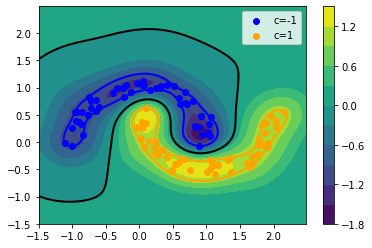

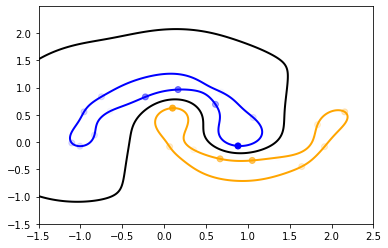

In [18]:
sigma = .3

# train
alphas = fit_svm(train_samples, train_labels, sigma)

# evaluate 
train_predictions = predict_svm(train_samples, train_samples, train_labels, alphas, sigma)
test_predictions = predict_svm(test_samples, train_samples, train_labels, alphas, sigma)

predicted_train_labels = np.ones(train_predictions.shape)
predicted_train_labels[train_predictions < 0] = -1
print("Train Accuracy: ", np.count_nonzero(predicted_train_labels == train_labels) / len(train_labels))

predicted_test_labels = np.ones(test_predictions.shape)
predicted_test_labels[test_predictions < 0] = -1
print("Test Accuracy: ", np.count_nonzero(predicted_test_labels == test_labels) / len(test_labels))

# plot train, contour, decision boundary and margins 
plt.figure()
plt_range = np.arange(-1.5, 2.5, 0.01)
plt_grid = np.stack(np.meshgrid(plt_range, plt_range), axis=-1)
flat_plt_grid = np.reshape(plt_grid, [-1, 2])
plt_grid_shape = plt_grid.shape[:2]

pred_grid = np.reshape(predict_svm(flat_plt_grid, train_samples, train_labels, alphas, sigma), plt_grid_shape)
plt.contour(plt_grid[..., 0], plt_grid[..., 1], pred_grid, levels=[-1, 0, 1], colors=('blue', 'black', 'orange'),
             linestyles=('-',), linewidths=(2,))
plt.contourf(plt_grid[..., 0], plt_grid[..., 1], pred_grid, levels=10)

plt.colorbar()

plt.scatter(x=train_samples[train_labels == -1, 0], y=train_samples[train_labels == -1, 1], label="c=-1", c="blue")
plt.scatter(x=train_samples[train_labels == 1, 0], y=train_samples[train_labels == 1, 1], label="c=1", c="orange")
plt.legend()

# plot margin, decision boundary and support vectors
plt.figure()
plt.contour(plt_grid[..., 0], plt_grid[..., 1], pred_grid, levels=[-1, 0, 1], colors=('blue', 'black', 'orange'),
             linestyles=('-',), linewidths=(2,))

# squeeze alpha values into interval [0, 1] for plotting
alphas_plt = np.clip(alphas / np.max(alphas), a_min=0.0, a_max=1.0)
for label, color in zip([-1, 1], ["blue", "orange"]):
    color_rgb = colors.to_rgb(color)
    samples = train_samples[train_labels == label]
    color_rgba = np.zeros((len(samples), 4))
    color_rgba[:, :3] = color_rgb
    color_rgba[:, 3] = alphas_plt[train_labels == label]
    plt.scatter(x=samples[:, 0], y=samples[:, 1], c=color_rgba)


plt.xlim(-1.5, 2.5)
plt.show()